In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [4]:
# Load the trained embeddings
print("Loading embeddings from cbow_text8.pt...")
checkpoint = torch.load("cbow_text8.pt", map_location='cpu')
embeddings = checkpoint['embeddings']
word_to_ix = checkpoint['word_to_ix']
ix_to_word = checkpoint['ix_to_word']

print(f"Loaded embeddings: {embeddings.shape}")
print(f"Vocabulary size: {len(word_to_ix)}")
print(f"Embedding dimension: {embeddings.shape[1]}")


Loading embeddings from cbow_text8.pt...
Loaded embeddings: torch.Size([47134, 200])
Vocabulary size: 47134
Embedding dimension: 200


In [5]:
def get_word_embedding(word: str) -> Optional[torch.Tensor]:
    """Get embedding for a specific word."""
    if word not in word_to_ix:
        return None
    idx = word_to_ix[word]
    return embeddings[idx]


In [6]:
def find_k_nearest_neighbors(
    query_vector: torch.Tensor, 
    k: int = 5, 
    metric: str = 'cosine',
    exclude_indices: Optional[List[int]] = None
) -> List[Tuple[str, int, float]]:
    """
    Find k nearest neighbors to a query vector in the embedding space.
    
    Args:
        query_vector: The query vector to find neighbors for
        k: Number of nearest neighbors to return
        metric: Distance metric ('cosine' or 'euclidean')
        exclude_indices: List of indices to exclude from search
        
    Returns:
        List of tuples (word, index, similarity/distance)
    """
    if exclude_indices is None:
        exclude_indices = []
    
    if metric == 'cosine':
        # Use the same approach as tester.py
        similarities = torch.cosine_similarity(query_vector.unsqueeze(0), embeddings)
        
        # Set excluded indices to very low similarity
        for idx in exclude_indices:
            similarities[idx] = -2.0
        
        # Get top k indices
        top_indices = similarities.topk(k)[1]
        
        # Return results with similarity scores
        results = []
        for idx in top_indices:
            word = ix_to_word[idx.item()]
            score = similarities[idx].item()
            results.append((word, idx.item(), score))
            
    elif metric == 'euclidean':
        # Compute euclidean distances
        distances = torch.norm(embeddings - query_vector, dim=1)
        
        # Set excluded indices to very high distance
        for idx in exclude_indices:
            distances[idx] = float('inf')
        
        # Get top k indices (smallest distances)
        top_indices = distances.topk(k, largest=False)[1]
        
        # Return results with distance scores
        results = []
        for idx in top_indices:
            word = ix_to_word[idx.item()]
            score = distances[idx].item()
            results.append((word, idx.item(), score))
    
    else:
        raise ValueError("Metric must be 'cosine' or 'euclidean'")
    
    return results


In [7]:
def find_similar_words(word: str, k: int = 5, metric: str = 'cosine') -> List[Tuple[str, int, float]]:
    """
    Find words most similar to a given word.
    
    Args:
        word: The input word
        k: Number of similar words to return
        metric: Distance metric ('cosine' or 'euclidean')
        
    Returns:
        List of tuples (word, index, similarity/distance)
    """
    if word not in word_to_ix:
        print(f"Word '{word}' not found in vocabulary!")
        return []
    
    # Get the word's embedding
    word_embedding = get_word_embedding(word)
    word_idx = word_to_ix[word]
    
    # Find neighbors, excluding the word itself
    neighbors = find_k_nearest_neighbors(word_embedding, k + 1, metric, exclude_indices=[word_idx])
    
    return neighbors[:k]


In [8]:
# Test with some example words
test_words = ["king", "computer", "good", "water", "red"]

for word in test_words:
    print(f"\n=== Words similar to '{word}' ===")
    similar = find_similar_words(word, k=5, metric='cosine')
    
    if similar:
        for i, (sim_word, idx, score) in enumerate(similar, 1):
            print(f"{i}. {sim_word:<15} (similarity: {score:.4f})")
    else:
        print(f"No similar words found (word might not be in vocabulary)")



=== Words similar to 'king' ===
1. kings           (similarity: 0.4616)
2. guelfs          (similarity: 0.3796)
3. kingdom         (similarity: 0.3680)
4. emperor         (similarity: 0.3644)
5. invading        (similarity: 0.3508)

=== Words similar to 'computer' ===
1. computers       (similarity: 0.4169)
2. mips            (similarity: 0.3938)
3. software        (similarity: 0.3743)
4. pc              (similarity: 0.3591)
5. os              (similarity: 0.3580)

=== Words similar to 'good' ===
1. alomari         (similarity: 0.3266)
2. amazing         (similarity: 0.3227)
3. unfortunate     (similarity: 0.3137)
4. elgar           (similarity: 0.3130)
5. deuteronomic    (similarity: 0.3124)

=== Words similar to 'water' ===
1. coating         (similarity: 0.3475)
2. tissues         (similarity: 0.3357)
3. compounds       (similarity: 0.3346)
4. reactions       (similarity: 0.3338)
5. surface         (similarity: 0.3294)

=== Words similar to 'red' ===
1. nylon           (similarity:

In [9]:
def word_analogy(word_a: str, word_b: str, word_c: str, k: int = 5):
    """
    Perform word analogy: word_a is to word_b as word_c is to ?
    
    Args:
        word_a, word_b, word_c: Words for the analogy
        k: Number of results to return
        
    Returns:
        List of candidate words for the analogy
    """
    # Check if all words are in vocabulary
    for word in [word_a, word_b, word_c]:
        if word not in word_to_ix:
            print(f"Word '{word}' not found in vocabulary!")
            return []
    
    # Get embeddings
    emb_a = get_word_embedding(word_a)
    emb_b = get_word_embedding(word_b)
    emb_c = get_word_embedding(word_c)
    
    # Compute analogy vector: word_b - word_a + word_c
    analogy_vector = emb_b - emb_a + emb_c
    
    # Exclude the input words from results
    exclude_indices = [word_to_ix[word_a], word_to_ix[word_b], word_to_ix[word_c]]
    
    # Find nearest neighbors
    results = find_k_nearest_neighbors(analogy_vector, k, metric='cosine', exclude_indices=exclude_indices)
    
    return results


In [10]:
# Test word analogies
analogies = [
    ("man", "king", "woman"),
    ("good", "better", "bad"), 
    ("big", "bigger", "small"),
    ("paris", "france", "london"),
    ("walk", "walking", "run")
]

for word_a, word_b, word_c in analogies:
    print(f"\n=== {word_a} is to {word_b} as {word_c} is to: ===")
    results = word_analogy(word_a, word_b, word_c, k=3)
    
    if results:
        for i, (word, idx, score) in enumerate(results, 1):
            print(f"{i}. {word:<15} (similarity: {score:.4f})")
    else:
        print("No results found")



=== man is to king as woman is to: ===
1. yes             (similarity: 0.3373)
2. banks           (similarity: 0.3182)
3. guelfs          (similarity: 0.3067)

=== good is to better as bad is to: ===
1. changed         (similarity: 0.3502)
2. ein             (similarity: 0.3209)
3. extracts        (similarity: 0.3184)

=== big is to bigger as small is to: ===
1. particulate     (similarity: 0.3271)
2. backgrounds     (similarity: 0.3142)
3. mustaine        (similarity: 0.3095)

=== paris is to france as london is to: ===
1. millionaires    (similarity: 0.3254)
2. pogrom          (similarity: 0.3023)
3. ready           (similarity: 0.3015)

=== walk is to walking as run is to: ===
1. rounding        (similarity: 0.3295)
2. span            (similarity: 0.2910)
3. thermodynamically (similarity: 0.2860)


## Visualization

Let's create a visualization of some words in the embedding space using PCA:


In [12]:
def visualize_words(words: List[str], title: str = "Word Embeddings Visualization"):
    """
    Visualize word embeddings in 2D using PCA.
    
    Args:
        words: List of words to visualize
        title: Title for the plot
    """
    # Filter words that exist in vocabulary
    valid_words = [word for word in words if word in word_to_ix]
    
    if len(valid_words) < 2:
        print("Not enough valid words for visualization!")
        return
    
    # Get embeddings for the words
    word_embeddings = []
    for word in valid_words:
        embedding = get_word_embedding(word).numpy()
        word_embeddings.append(embedding)
    
    word_embeddings = np.array(word_embeddings)
    
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(word_embeddings)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, s=100)
    
    # Add word labels
    for i, word in enumerate(valid_words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    plt.title(title)
    plt.xlabel(f'PC1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Successfully visualized {len(valid_words)} words out of {len(words)} requested.")
    if len(valid_words) < len(words):
        missing = [word for word in words if word not in word_to_ix]
        print(f"Words not found in vocabulary: {missing}")


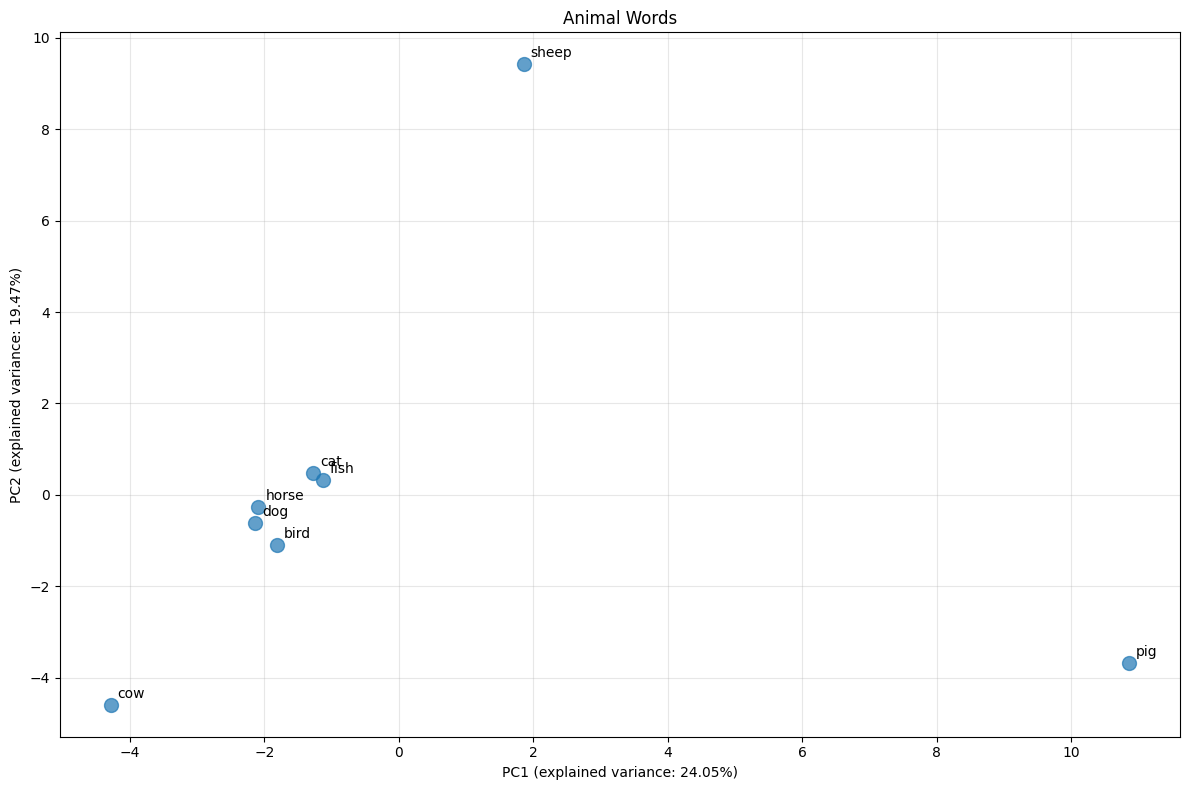

Successfully visualized 8 words out of 8 requested.


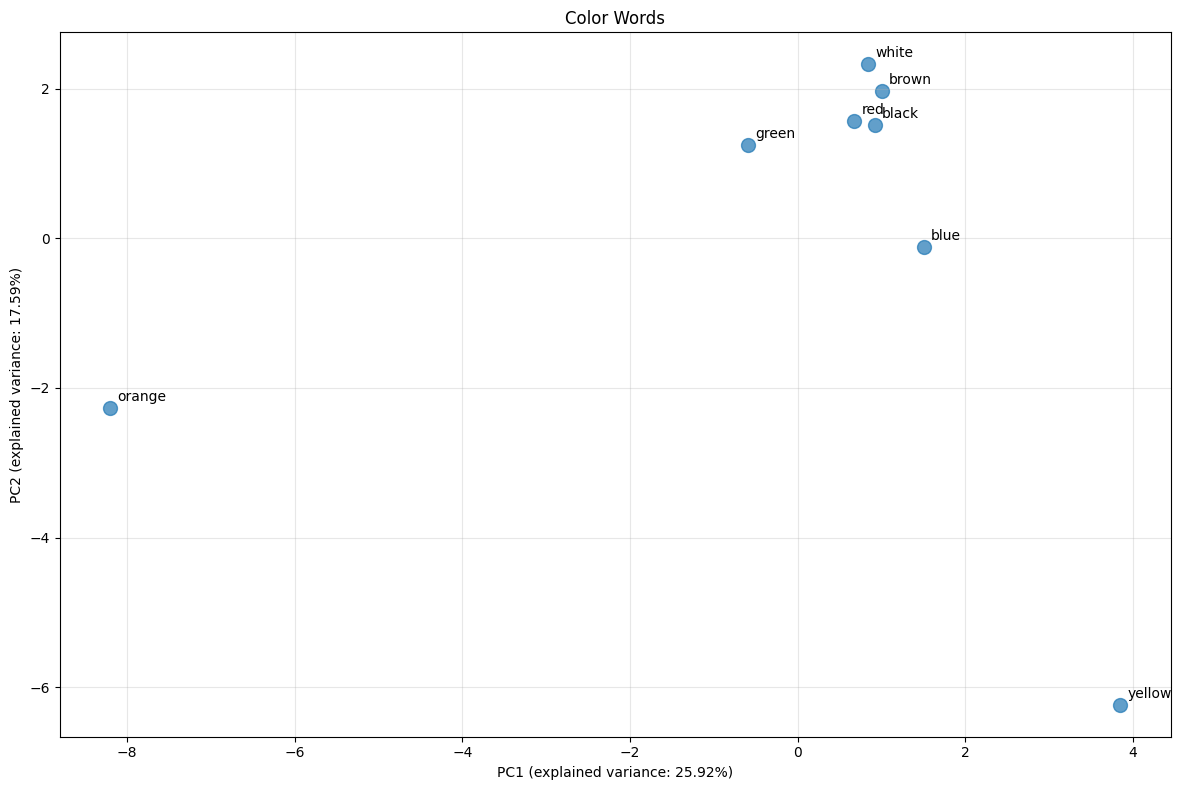

Successfully visualized 8 words out of 8 requested.


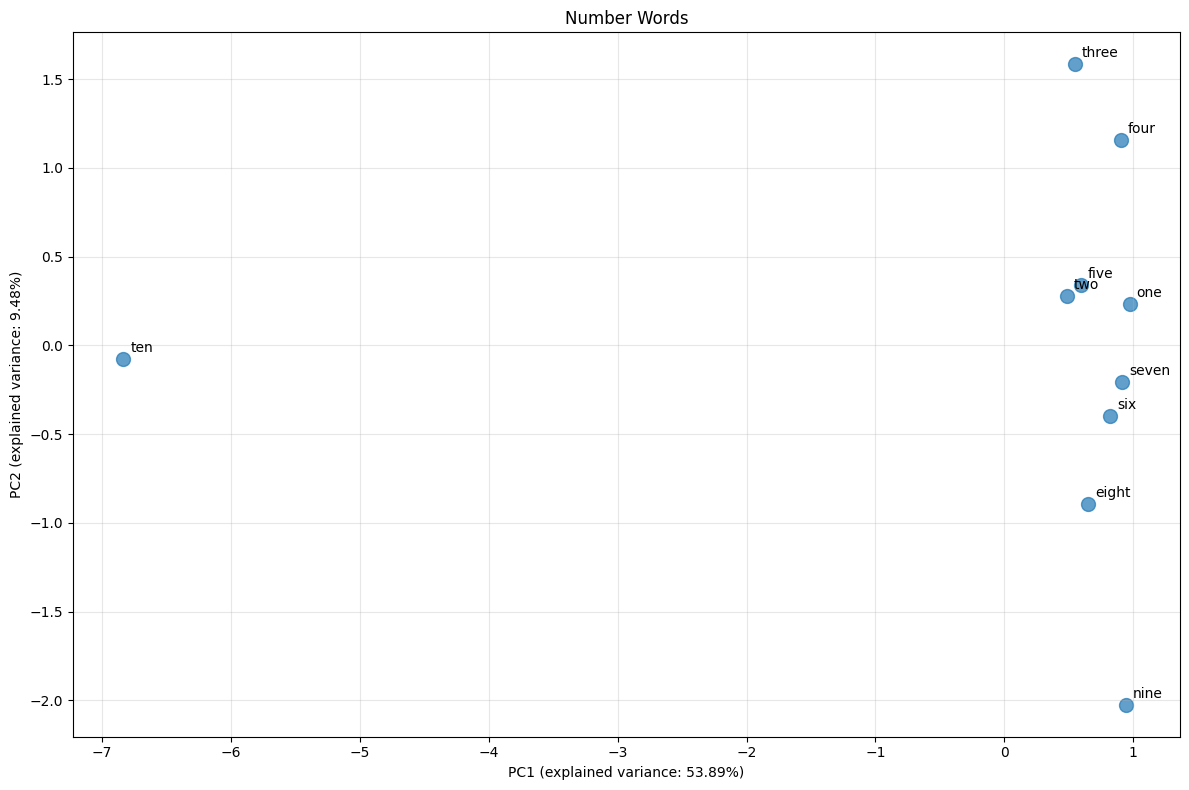

Successfully visualized 10 words out of 10 requested.


In [13]:
# Visualize some related words
animal_words = ["dog", "cat", "horse", "cow", "pig", "sheep", "bird", "fish"]
color_words = ["red", "blue", "green", "yellow", "black", "white", "brown", "orange"]
number_words = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"]

# Visualize different categories
visualize_words(animal_words, "Animal Words")
visualize_words(color_words, "Color Words") 
visualize_words(number_words, "Number Words")


In [15]:
# Interactive functions - modify these to test your own words!

# Find similar words
your_word = "education"  # Change this to any word you want to test
print(f"Words similar to '{your_word}':")
similar = find_similar_words(your_word, k=10)
if similar:
    for i, (word, idx, score) in enumerate(similar, 1):
        print(f"{i:2d}. {word:<15} (similarity: {score:.4f})")

print("\n" + "="*50 + "\n")

# Custom analogy
a, b, c = "he", "his", "she"  # Change these words
print(f"Analogy: {a} is to {b} as {c} is to:")
results = word_analogy(a, b, c, k=5)
if results:
    for i, (word, idx, score) in enumerate(results, 1):
        print(f"{i}. {word:<15} (similarity: {score:.4f})")


Words similar to 'education':
 1. school          (similarity: 0.3654)
 2. schools         (similarity: 0.3486)
 3. pilgrim         (similarity: 0.3152)
 4. counteracting   (similarity: 0.3129)
 5. disconnect      (similarity: 0.3035)
 6. punk            (similarity: 0.2978)
 7. psychiatric     (similarity: 0.2978)
 8. curricula       (similarity: 0.2950)
 9. requirements    (similarity: 0.2931)
10. levies          (similarity: 0.2930)


Analogy: he is to his as she is to:
1. her             (similarity: 0.3983)
2. their           (similarity: 0.3787)
3. s               (similarity: 0.3384)
4. divorce         (similarity: 0.3295)
5. your            (similarity: 0.3101)


In [21]:
# Example: Create a custom vector by averaging multiple word embeddings
words_to_average = ["happy", "joy", "smile", "laugh"]
print(f"Creating average vector from: {words_to_average}")

valid_words = [w for w in words_to_average if w in word_to_ix]
if len(valid_words) > 0:
    word_embeddings = [get_word_embedding(w) for w in valid_words]
    average_vector = torch.stack(word_embeddings).mean(dim=0)
    
    print(f"Successfully averaged {len(valid_words)} words")
    print("Words most similar to this 'happiness' concept:")
    
    # Exclude the original words from results
    exclude_indices = [word_to_ix[w] for w in valid_words]
    results = find_k_nearest_neighbors(average_vector, k=8, exclude_indices=exclude_indices)
    
    for i, (word, idx, score) in enumerate(results, 1):
        print(f"{i}. {word:<15} (similarity: {score:.4f})")
else:
    print("None of the words found in vocabulary!")


Creating average vector from: ['happy', 'joy', 'smile', 'laugh']
Successfully averaged 4 words
Words most similar to this 'happiness' concept:
1. always          (similarity: 0.3419)
2. masurian        (similarity: 0.3179)
3. spoon           (similarity: 0.3162)
4. shorty          (similarity: 0.3142)
5. abdicated       (similarity: 0.3137)
6. speculate       (similarity: 0.3076)
7. ascending       (similarity: 0.2981)
8. raining         (similarity: 0.2939)
